In [12]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from LCNE_patchseq_analysis.pipeline_util.metadata import read_brian_spreadsheet, cross_check_metadata

##  Load patchseq metadata and perform cross check

In [ ]:
# If run in CO, we cannot access LIMS
dfs = read_brian_spreadsheet(file_path="/root/capsule/data/IVSCC_LC_summary.xlsx", add_lims=False)
for source in ["tab_xyz", "tab_ephys_fx"]:
    df_inconsistencies = cross_check_metadata(dfs["df_merged"], source)

### ❌ Oh no! These inconsistencies must be caused by manually copying and pasting across the tabs!!!

# Analysis based on spreadsheet

In [15]:
import seaborn as sns
import pandas as pd

from LCNE_patchseq_analysis.data_util.metadata import load_ephys_metadata

In [16]:
df = load_ephys_metadata()
list(df.columns[60:132])

['sag',
 'sag_area',
 'sag_tau',
 'v_baseline',
 'rheobase_i',
 'fi_fit_slope',
 'vm_for_sag',
 'input_resistance',
 'input_resistance_ss',
 'tau',
 'latency_rheo',
 'avg_rate_rheo',
 'mean_isi_rheo',
 'upstroke_downstroke_ratio_rheo',
 'threshold_v_rheo',
 'peak_v_rheo',
 'width_rheo',
 'upstroke_rheo',
 'downstroke_rheo',
 'width_suprathresh_rheo',
 'trough_v_rheo',
 'fast_trough_v_rheo',
 'postap_slope_rheo',
 'fast_trough_v_last_rheo',
 'adp_v_last_rheo',
 'adapt_hero',
 'avg_rate_hero',
 'latency_hero',
 'mean_isi_hero',
 'median_isi_hero',
 'isi_cv_hero',
 'ir_late_hero',
 'upstroke_downstroke_ratio_hero',
 'threshold_v_hero',
 'peak_v_hero',
 'width_hero',
 'upstroke_hero',
 'downstroke_hero',
 'width_suprathresh_hero',
 'trough_v_hero',
 'fast_trough_v_hero',
 'postap_slope_hero',
 'ahp_delay_ratio_hero',
 'sag_depol',
 'sag_area_depol',
 'sag_tau_depol',
 'adapt_mean',
 'isi_cv_mean',
 'ir_late_mean',
 'avg_rate_max',
 'isi_adapt_ratio',
 'width_adapt_ratio',
 'upstroke_adapt_

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Embedded shape: (271, 2)


Text(0, 0.5, 'UMAP‑2')

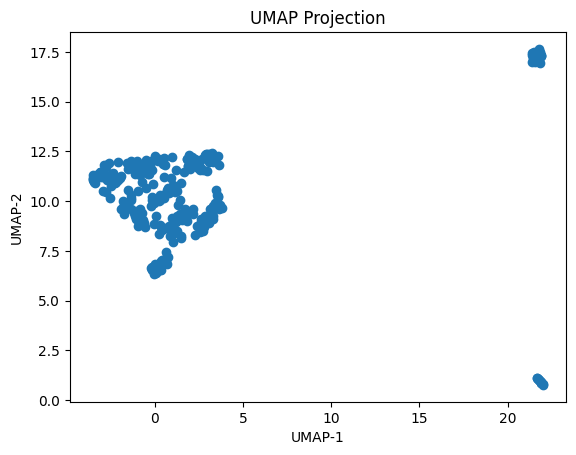

In [ ]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

# Create a toy dataset (100 samples × 50 features)
X = df.iloc[:, 60:132].values

# Remove columns that has NaN
X = np.nan_to_num(X)
X.shape

# Initialize UMAP
umap_model = UMAP(
    n_neighbors=15,    # how many nearest neighbors to consider
    min_dist=0.1,      # how tightly points are packed
    n_components=2,    # target dimensionality
    random_state=42    # reproducibility
)

# Fit & transform
X_embedded = umap_model.fit_transform(X)
print("Embedded shape:", X_embedded.shape)

# 4️⃣ Visualize
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title("UMAP Projection")
plt.xlabel("UMAP‑1")
plt.ylabel("UMAP‑2")

In [19]:
cols_width = [col for col in df.columns if ("width" in col and "adapt_ratio" not in col)]
cols_width

['width_rheo',
 'width_suprathresh_rheo',
 'width_hero',
 'width_suprathresh_hero',
 'width_short_square',
 'width_suprathresh_short_square']

In [20]:
# Find out NaN values
df[cols_width].isna().sum()


width_rheo                        42
width_suprathresh_rheo            42
width_hero                        43
width_suprathresh_hero            43
width_short_square                50
width_suprathresh_short_square    55
dtype: int64

In [21]:
df["injection region"].unique()

def _format_injection_region(x):
    if x != x:
        return "None"
    if "pl" in x.lower():
        return "Cortex"
    return x
    
df["injection region"] = df["injection region"].apply(_format_injection_region)

In [22]:
df["injection region"].unique()

array(['None', 'C5', 'Cortex', 'VAL', 'Crus 1'], dtype=object)

In [23]:
df_width = df[["injection region", "y_tab_master"] + cols_width].copy()

# Set any value in cols_widths > 0.01 to None
df_width[cols_width] = df_width[cols_width].mask(df_width[cols_width] > 0.01, None) * 1000 # in ms

# Specify the desired order
area_order = ["None", "C5", "Cortex", "VAL", "Crus 1"]
color_order = ["lightgrey", "pink", "green", "red", "gold"]

# Convert the column to a categorical type with the given order
df_width["injection region"] = pd.Categorical(df_width["injection region"], categories=area_order, ordered=True)

# Sort the DataFrame by the categorical column
df_width = df_width.sort_values("injection region")
df_width.rename(columns={"y_tab_master": "y (D -> V)"}, inplace=True)


<Axes: xlabel='y (D -> V)', ylabel='Density'>

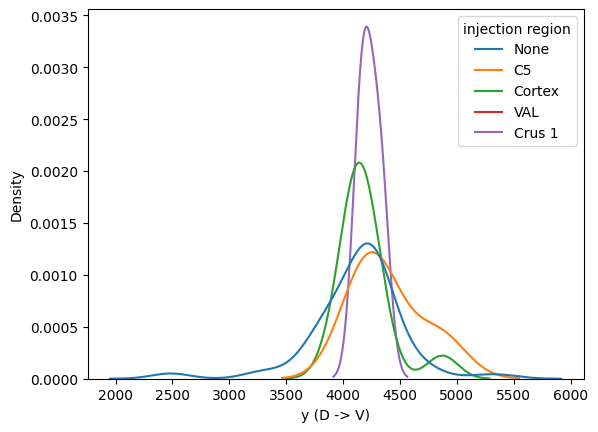

In [24]:
sns.kdeplot(
    data=df_width,
    x="y (D -> V)",
    hue="injection region",
    common_norm=False,
    # kde=True,
    # stat="count",
    # bins=50,
    color="black",
)

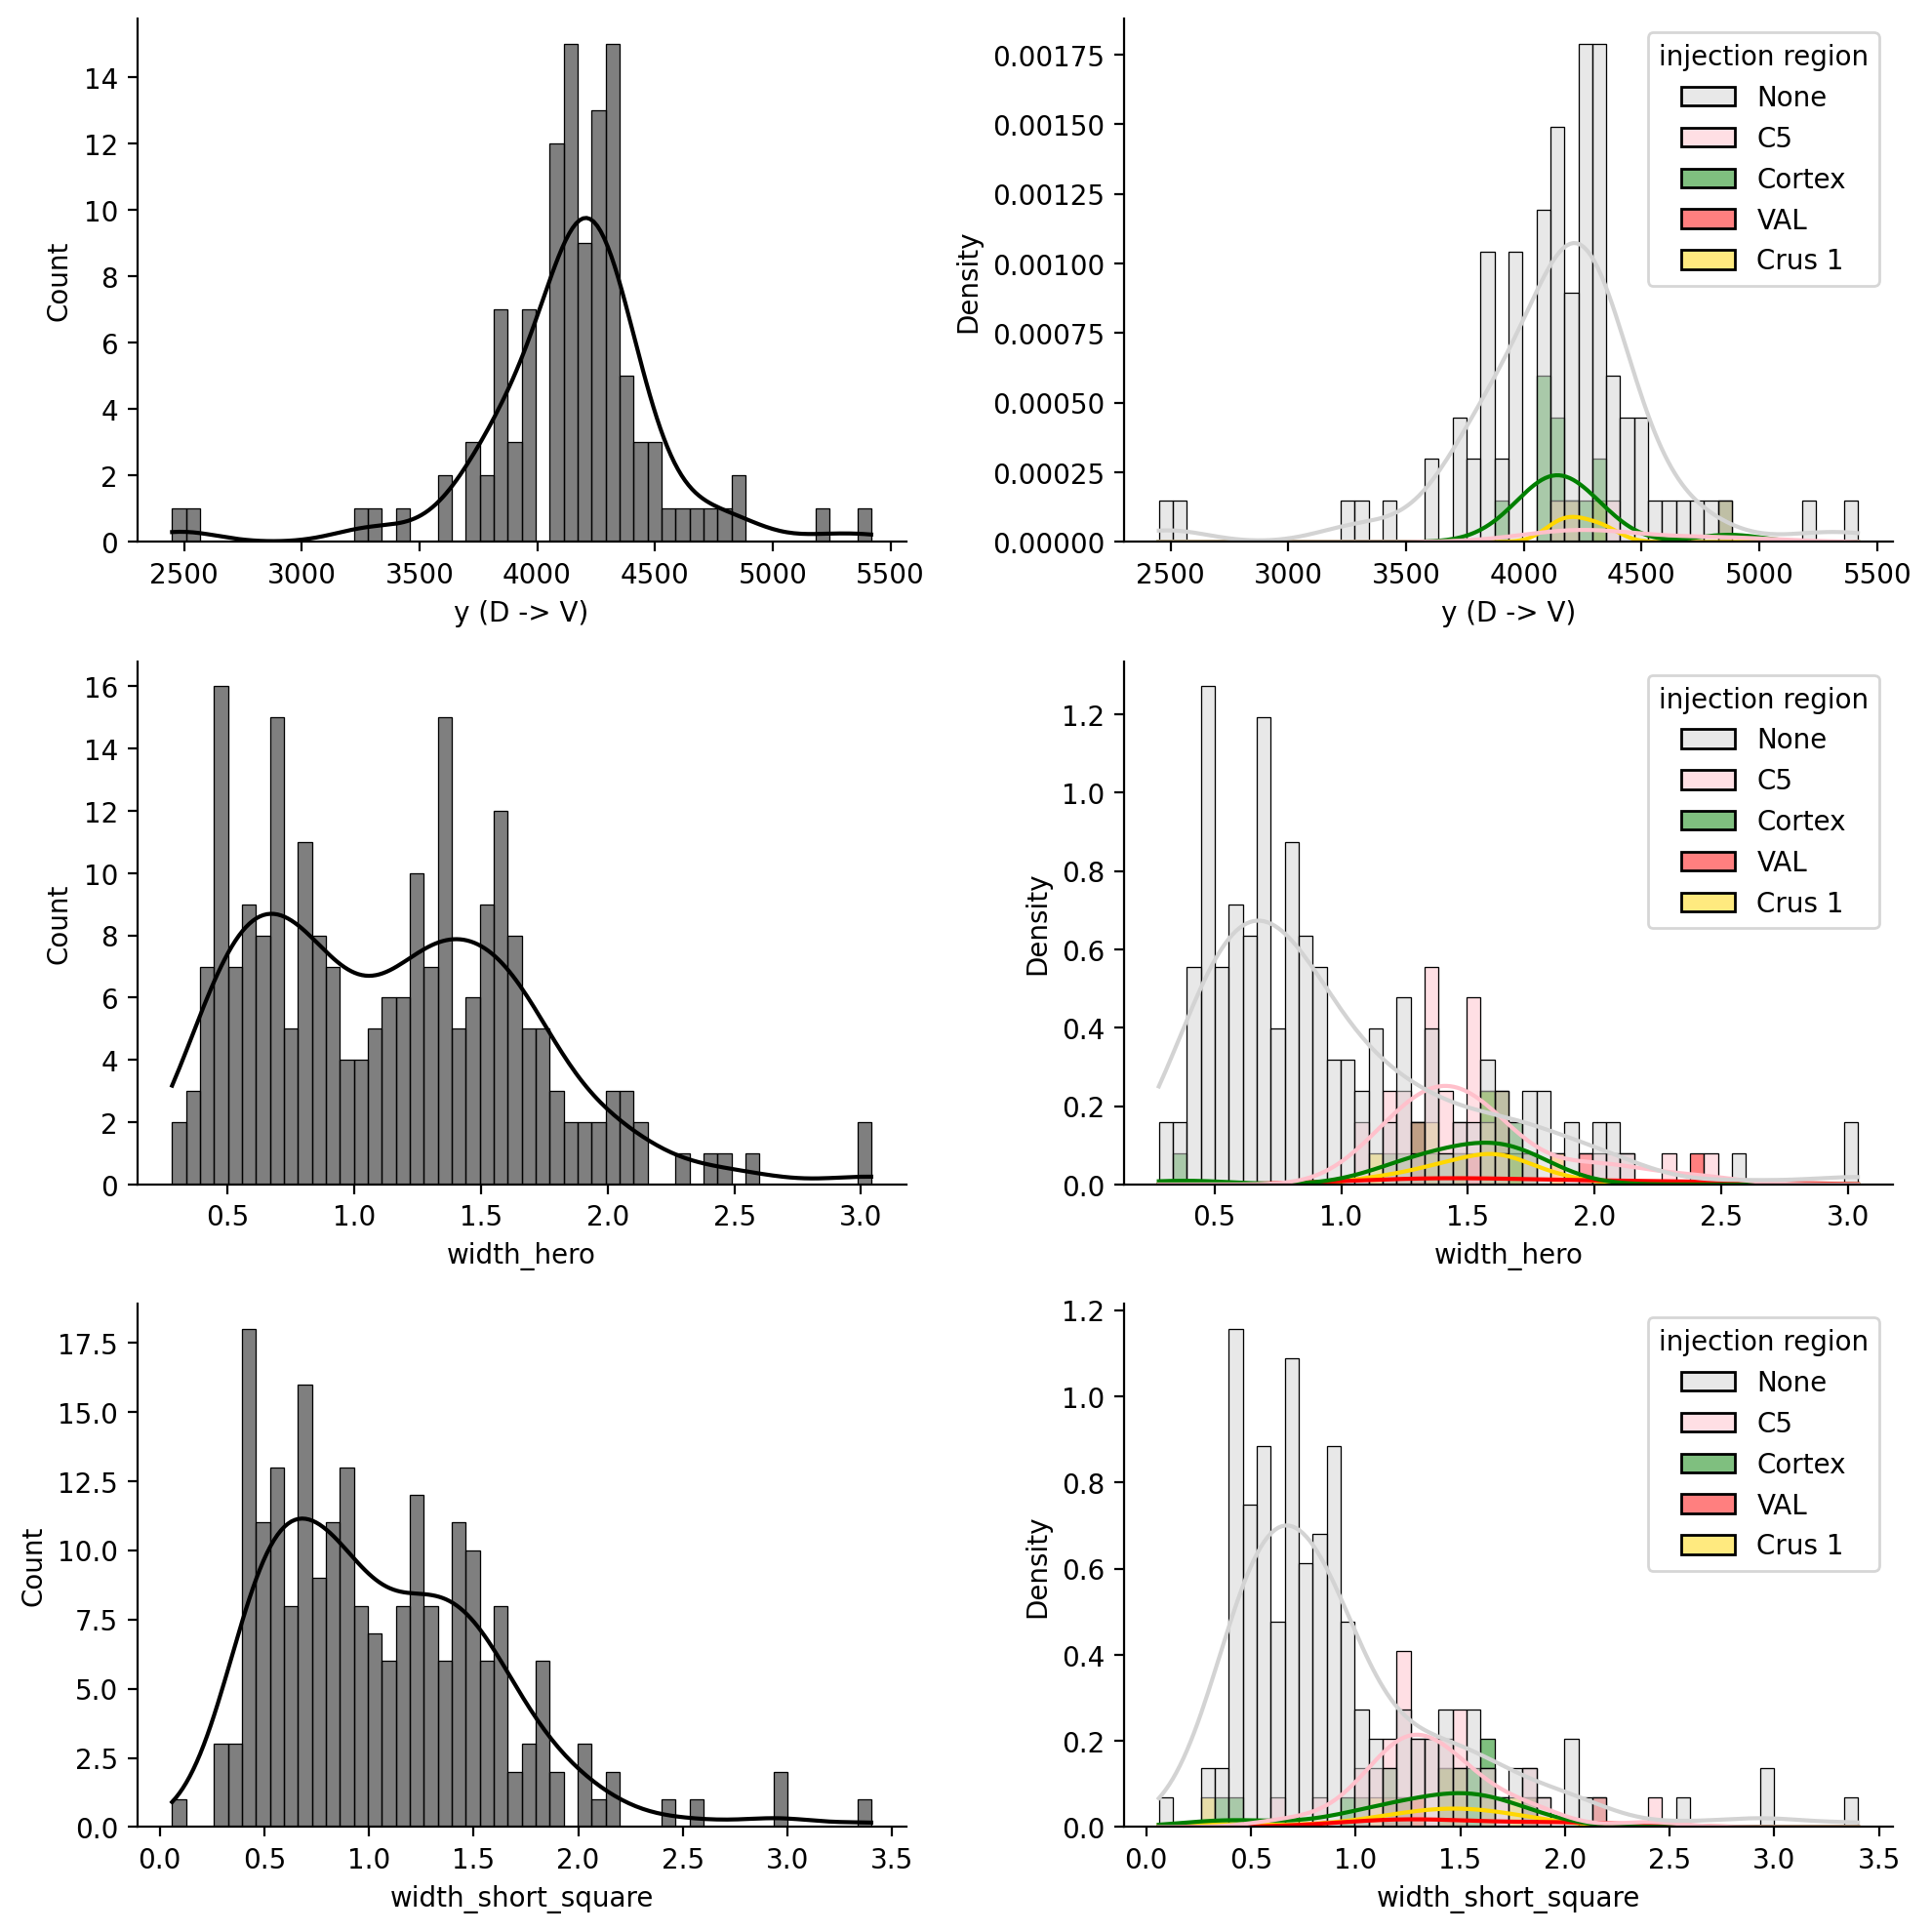

In [25]:
width = ["y (D -> V)", "width_hero", "width_short_square"]
fig, ax = plt.subplots(len(width), 2, figsize=(10, 10))

for i, x in enumerate(width):
    sns.histplot(
        data=df_width,
        x=x,
        kde=True,
        stat="count",
        bins=50,
        color="black",
        ax=ax[i, 0],
    )
    sns.histplot(
        data=df_width,
        x=x,
        kde=True,
        hue="injection region",
        hue_order=area_order,
        palette=color_order,
        stat="density",
        bins=50,
        ax=ax[i, 1],
    )

sns.despine()
fig.tight_layout()
fig.set_dpi(200)

In [26]:
df.y_tab_master.notna().sum()

np.int64(113)

In [27]:
df_width["y (D -> V)"]

0              NaN
171    4059.010010
172    4252.699707
173            NaN
174            NaN
          ...     
87             NaN
85             NaN
84             NaN
103    4144.880370
86             NaN
Name: y (D -> V), Length: 271, dtype: float64

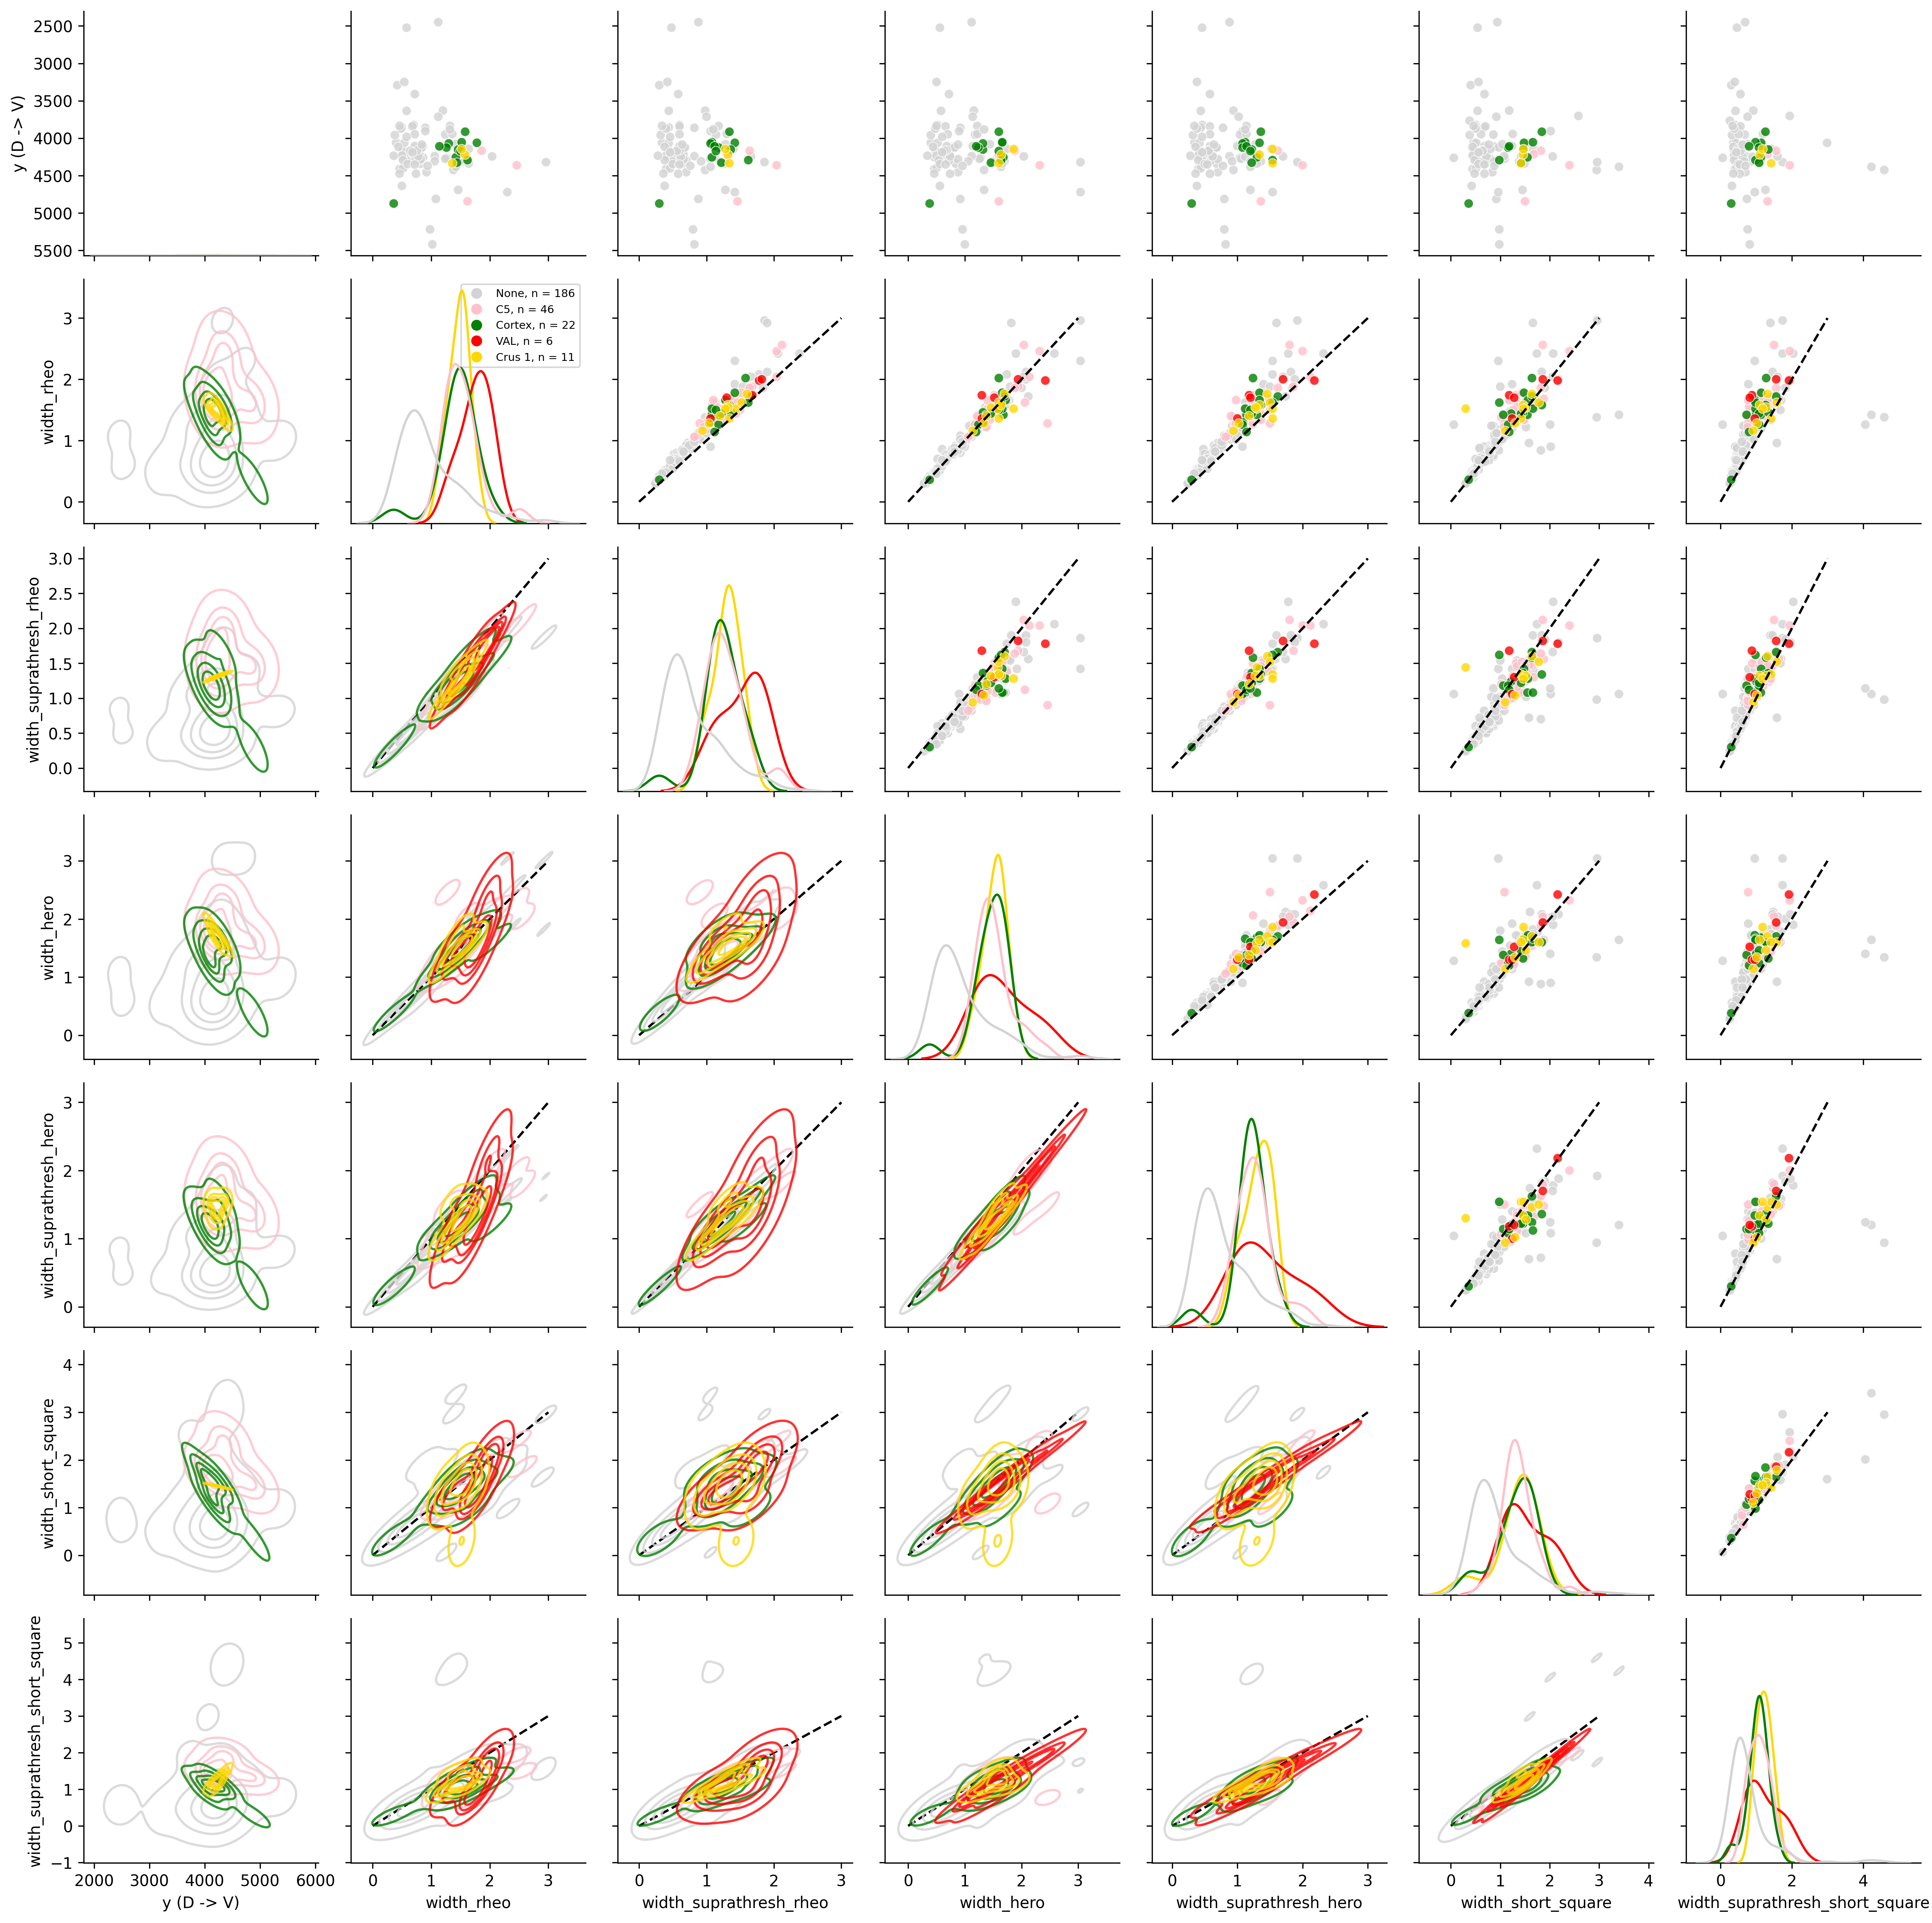

In [29]:
import matplotlib.pyplot as plt

g = sns.PairGrid(
    df_width,
    hue="injection region",
    hue_order=area_order,
    palette=color_order,
)

# Add a diagnoal line
axes = g.axes
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        if i != j and i > 0 and j > 0:
            axes[i, j].plot([0, 3], [0, 3], '--k')
            # axes[i, j].set_xlim(0, 5)
            # axes[i, j].set_ylim(0, 5)
        if i == 0 and j == 0:
            # invert y axis
            axes[i, j].invert_yaxis()


g.map_upper(sns.scatterplot, alpha=0.8)
g.map_lower(sns.kdeplot, fill=False, alpha=0.8, common_norm=False, levels=5)
g.map_diag(sns.kdeplot, common_norm=False, legend=True)

g.fig.set_dpi(300)            

# Create legend handles manually.
handles = [
    plt.Line2D(
        [],
        [],
        marker="o",
        linestyle="",
        color=color,
        label=f"{area}, n = {len(df_width[df_width['injection region'] == area])}",
    )
    for area, color in zip(
        area_order,
        color_order,
    )
]

# Add the legend to the selected diagonal axis.
g.axes[1, 1].legend(handles=handles, loc="upper right", fontsize=7)